# Mark: 81

### Notes: Good work overall. Answers qualitatively correct for the most part, but the number of eigenvalues used is often not sufficient to obtain the solutions to the right numerical accuracy. Code is generally well written, with only minor issues.

### Task 1: 25/25
Good work.

### Task 2: 5/5
Good work.

### Task 3: 19/20
Good work; there's just a small mistake in the definition of the Gaussian, missing out a factor of 0.5; adding this fixes the shapes of the wavefunctions to the correct ones (though it doesn't affect the mean in this task).

### Task 4: 5/10
The potential looks largely correct, but using integer arithetic to obtain it is not the most practical method to obtain it in the code. It is also best done on the same spatial grid as before since the points look rather coarse, making the edges look not as steep as they should.
Otherwise, a good attempt on the wavefunction calculation, but missing a calculation of the mean. Adding the snippet of code used previously gives a mean of around 55.2, which is close but not quite correct. This is likely because the number of eigenvalues used is not sufficient.

### Task 5: 14/15
A good attempt; the calculated value is close but not quite correct, likely because of the initial condition and a fairly large timestep for the time integration. This timestep can be reduced a fair amount because the spectral method makes it computationally cheap to calculate solutions at arbitrary times.

### Task 6: 11/15
The plot looks qualitatively correct, but the timestep is not sufficiently small to obtain numerically accurate answers for the time integration of the current.

### Task 7: 2/10
Unfortunately the probability is too high, which is because the potential created is not truly disordered. Each realisation of the potential should have a random width for each i=0,1,...,100 rather than a single random width for all of them. Such a disordered potential would lead to a much smaller probability, which is due to localisation.

# Checkpoint 2

**Due: Friday, 6 November, 2020 at 5:00pm GMT**

### Read This First
1. Use the constants provided in the cell below. Do not use your own constants.

2. Put the code that produces the output for a given task in the cell indicated. You are welcome to add as many cells as you like for imports, function definitions, variables, etc. **Additional cells need to be in the proper order such that your code runs correctly the first time through.**

3. **IMPORTANT!** Before submitting your notebook, clear the output by clicking *Restart & Clear Output* from the *Kernel* menu. If you do not do this, the file size of your notebook will be very large.

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time

from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import spsolve
from scipy.sparse import diags
from scipy.sparse import identity
from scipy.linalg import eigh_tridiagonal
import scipy.integrate

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 16

# Task 1 (25p)

Find numerically the first 101 lowest eigenvalues (“energies”) of the discrete Hamiltonian matrix, H, for V=0 and x=0,...,L, with L=100, dx=1/8 and with reflecting boundary conditions:

$
\begin{align}
\psi_N \equiv \psi_{N-1},
\end{align}
$

$
\begin{align}
\psi_{-1} \equiv \psi_0,
\end{align}
$

Here the index -1 denotes the element to the left of the element zero, not the element N-1 as in Python. Note that indices $-1, N$ refer to elements of $\psi$ that are outside the matrix H.

Hint: The eigenvalues, $w_n$, should be

$
\large
\begin{align}
w_n = \frac{2\left(1 - \cos (\frac{n \pi}{N}) \right)}{dx^2}
\end{align}
$

for n=0, 1,..., 100. The corresponding (non-normalized) eigenvectors, $v_n$ are

$
\large
\begin{align}
v_n = \cos \left( \frac{n \pi x}{L} \right)
\end{align}
$

for x=0, dx,..., (N-1)dx.

In [61]:
### Values for task 1
L  = 100
dx = 1/8
N  = int(L/dx)
print(f"Matrix size: {N}.")

Matrix size: 800.


In the cell below, compute the 101 lowest eigenvalues given the values of V, L, and dx from above. The function, `task1` should return an array of the eigenvalues.

It may be useful to write a generalized function for creating the Hamiltonian given values of N, dx, and V.

In [63]:
def hamiltonian(dx):
    N = int(L/dx)
    laplace = [(-2) * np.ones(N), np.ones(N-1), np.ones(N-1)]
    # diags function is used for converting this data structure into NxN array
    LHS = diags(laplace, [0,-1,1]).toarray()
    H = -1/dx**2 * LHS
    H[0][0] = H[1][1]/2
    H[N-1][N-1] = H[1][1]/2
    return H

def task1():
    # hamiltonian function is used for calculating the first 101 eigenvalues
    H = hamiltonian(dx)
    vv, ww = eigsh(H, 101, which = "SM")
    E = np.sort(np.real(vv))
    return E

## Testing task 1

The cell below will run your function and compare it with the expected values.

Time to solution: 0.21420741081237793 seconds.


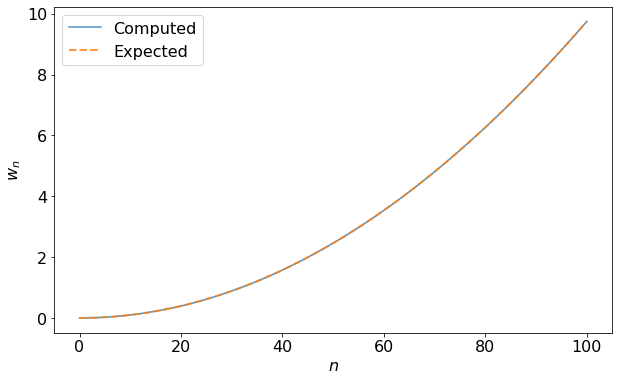

Max difference is 4.192421823934871e-12.


In [64]:
t1 = time.time()
ww = task1()
t2 = time.time()
print (f"Time to solution: {t2-t1} seconds.")

my_n = np.arange(101)
ww_expected = 2 * (1 - np.cos(my_n*np.pi/N)) / dx**2

plt.plot(my_n, ww, label='Computed', alpha=0.8)
plt.plot(my_n, ww_expected, label='Expected', linewidth=2, linestyle='--', alpha=0.8)
plt.xlabel(r'$n$')
plt.ylabel(r'$w_{n}$')
plt.legend()
plt.show()

diff = np.abs(ww - ww_expected) / np.max(np.abs([ww, ww_expected]), axis=0)
print (f"Max difference is {diff[1:].max()}.")
assert (diff[1:] < 1e-6).all()

# Task 2 (5p)

Select dx as a negative power of two ($dx=2^{-n}$ for n>0) such that the 101th eigenvalue differs from the dx$\rightarrow$0 limiting value of

$
\begin{align}
w_{101,exact} = \frac{(100\pi/N)^{2}}{dx^2}
\end{align}
$

by less than 0.1%, i.e., $|w_{101}/w_{101,exact}-1|<0.001$.

Motivation: selecting a sufficiently small dx is required to obtain a good approximation to the original (continuous) equation (1) for subsequent tasks.

In the cell below, compute a value of dx that satisfies the above contraint. The function `task2` should return the value of dx that you have calculated.

In [65]:
def task2():
    # While loop was used in order to reach the new value dx
    du = dx
    sol_101 = np.pi**2
    help_no = 0
    while(abs((help_no/sol_101) - 1) > 0.001):
        du = du/2
        H = hamiltonian(du)
        vv, ww = eigsh(H, 101, which = "SM")
        E = np.sort(np.real(vv))
        help_no = E[100]
    return du

## Testing task 2

The cell below will run the `task2` function. We will verify that value of dx return satisfies the criterion outlined above.

In [66]:
t1 = time.time()
my_dx = task2()
t2 = time.time()
print (f"Time to solution: {t2-t1} seconds.")

### BEGIN HIDDEN TESTS

def create_ham(N, dx, varray=None):
    if varray is None:
        varray = np.zeros(N)

    diagonals = [np.full((N),  -2./dx**2),
                 np.full((N-1), 1./dx**2),
                 np.full((N-1), 1./dx**2)]
    diagonals[0][0]=-1./dx**2  # reflecting boundary conditions
    diagonals[0][-1]=-1./dx**2 # reflecting boundary conditions
    delta = diags(diagonals, [0, -1, 1])

    V = diags(varray)
    H = -delta + V
    return H

my_N = int(L/my_dx)

my_ham = create_ham(my_N, my_dx)
my_ww, my_vv = eigsh(my_ham, 101, which="SA")

w100_exact = (100*np.pi/my_N)**2 / my_dx**2
my_diff = np.abs(my_ww[100]/w100_exact - 1)
print (f"Diff is {my_diff}.")
assert my_diff <= 1e-3

### END HIDDEN TESTS

Time to solution: 18.65436887741089 seconds.
Diff is 0.0008029324608007649.


# Task 3 (20p)

Solve equation (1) with the initial condition (2) (the Schroedinger equation and the Gaussian function from the checkpoint's description) for V(x)=0, on a domain x=0...100, for t=0...4 and dx from task 2. Plot $|\psi(x,t)|^2$ and determine its mean given by

$
\large
\begin{align}
<x>\ = \int_{0}^{100} |ψ(x)|^2 x dx.
\end{align}
$

The mean should be equal to 79$\pm$-1.

Hint: use the procedure for creating the Hamiltonian matrix from tasks 1, 2. This will reduce the amount of coding required.

In [67]:
### Constants for task 3 and 4
x0     = 15
v      = 16
sigma2 = 5
tmax   = 4

## Task 3 plot and result

In the cell(s) below, do the following:
1. Solve equation (1) for t=0...4 and plot $|\psi(x,t=0)|^2$ and $|\psi(x,t=tmax)|^2$ as a function of x.
2. Compute the mean of the final position and print the value. The correct result should be between 78 and 80.

Don't forget to nomalize your Gaussian initial condition so that the total probability $\int_0^L |\psi(x,t=0)|^2 dx=1$. 

You do not have to wrap up the calculation in a function "task3()", but doing so may help to reduce the amount of coding for tasks 4-6.

In [68]:
def wavefunction_zero(u):
    # Rather than using task2() function again, I just overrode the value dx declared at the beginning as dx = 1/32; 
    # I did the same thing for N
    # The initial wavefunction is calculated here
    dx = 1/32
    N = int(L/dx)
    arr = np.linspace(0,L,N)
    arr_x0 = np.ones(N) * x0
    psi_x = np.exp(-(arr-arr_x0)**2/sigma2 + arr * u *1j/2)
    psi_conjugate = psi_x.conjugate()
    wavefunc = psi_x * psi_conjugate
    # The wavefunction is normalized using Simpsons' rule
    sum = scipy.integrate.simps(wavefunc, arr)
    wavefunc = wavefunc/sum
    psi_x = psi_x/np.sqrt(sum) 
    sum_x = 0
    for i in range(N):
        sum_x += wavefunc[i] * arr[i] * dx 
    # Both the solution to Schrodinger Eq in complex form and the wavefunction (its absolute value) are returnes
    return psi_x, wavefunc

In [69]:
def hamilton(dx):
    # The function is similar to the hamiltonian, but the data type is no longer converted into an NxN array,
    # as it can be used easier in eigh_tridiagonal function, reducing the computing time
    N = int(L/dx)
    main_diag = (2/(dx**2)) * np.ones(N)
    off_diag = (-1/(dx**2)) * np.ones(N-1)
    main_diag[0] = main_diag[1]/2
    main_diag[N-1] = main_diag[1]/2
    return main_diag, off_diag

The expected position of the wave-particle after tmax = 4s is: 78.33323790415426


/home/seb/miniconda3/envs/numrec/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/seb/miniconda3/envs/numrec/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


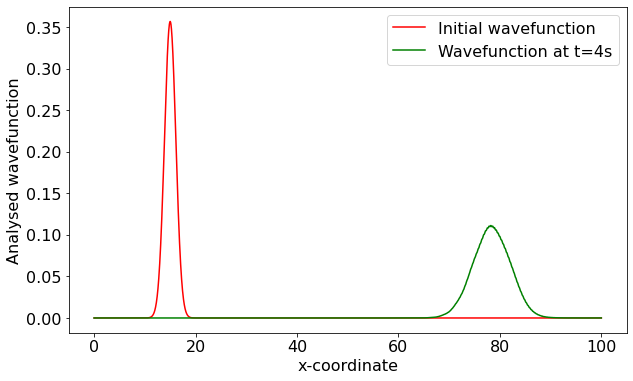

In [70]:
def task3():
    # Task 3 is about the wavefunction after t = 4s
    dx = 1/32
    N = int(L/dx)
    arr = np.linspace(0,L,N)
    # Initialise the wavefunction
    psi_x, wavefunc = wavefunction_zero(v)
    # Get the eigenvectors and eigenvalues of hamiltonian H
    main, off = hamilton(dx)
    evals, evecs = eigh_tridiagonal(main, off, select = 'i', select_range = (0,300))

    # Update the wavefunction position and the corresponding pdf
    a = evecs.T.dot(psi_x)
    # plot the first smallest values, this has been done only as a sanity check
    """for i in np.abs(evals).argsort()[:4]:
        plt.plot(arr, evecs[:,i])
    plt.show()"""

    u = np.zeros(N, dtype = np.complex128) 
    # The spectral method has been used 
    for i in range (evals.size):
        u += a[i] * np.exp(evals[i] * tmax * (-1j)) * evecs[:,i]
        
    u_x = u * np.conjugate(u)
    sum = scipy.integrate.simps(u_x, arr)
    u_x = u_x/sum
    
    # Print the expected x-coordinate using the given formula
    x_expected = 0
    for i in range(N):
        x_expected += arr[i] * u_x[i] * dx
    print("The expected position of the wave-particle after tmax = 4s is: " + str(abs(x_expected)))

    plt.plot(arr, wavefunc, color = 'r', label = "Initial wavefunction")
    plt.plot(arr, u * np.conjugate(u), color = 'g', label = "Wavefunction at t=4s")
    plt.legend()
    plt.xlabel("x-coordinate")
    plt.ylabel("Analysed wavefunction")
    plt.show()

task3()

# Task 4 (10p)

Now repeat task 3 for a potential made up of regularly spaced wells such that

V=70 for |x-i| < 0.25 where i=0,1,...,100,

and V=0 elsewhere.

Plot the potential. It should be $V=70$ for $x=0...0.25$, $V=0$ for $x=0.25...0.75$, $V=70$ for $x=0.75...1.25$, and so on.

Determine the mean of $|\psi(x,t)|^2$ as before, with accuracy $\pm$1.

Make sure that dx and dt are sufficiently small to achieve this accuracy!

In the cell below, create the potential and plot it over the range [0, 3].

In [71]:
# This function is used for plotting the wavefunction with the potential wells
def hamiltonian_VPot(dx):
    N = int(L/dx)
    main_diag = (2/(dx**2)) * np.ones(N)
    off_diag = (-1/(dx**2)) * np.ones(N-1)
    main_diag[0] = main_diag[1]/2
    main_diag[N-1] = main_diag[1]/2
    for i in range(N):
        if(i % 32 < 9 or i % 32 > 25):
            main_diag[i] += 70
    return main_diag, off_diag

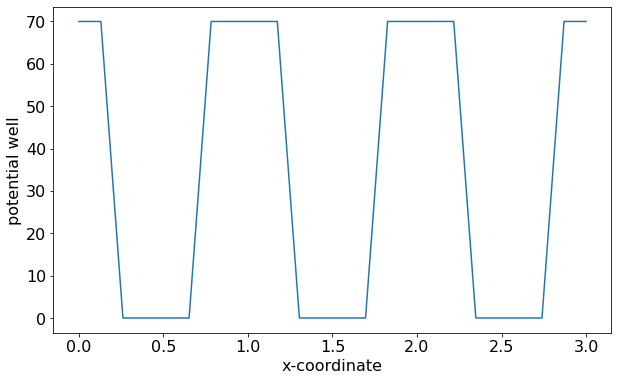

In [72]:
def plot_potential():
    # The potential wells are plotted in the interval [0,3]
    L = 3
    dx = 1/8
    N = int(L/dx)
    V = np.zeros(N)
    arr = np.linspace(0,L,N)
    """dx = 1/32       
    for i in range(N):
        if(i % 32 > 8):
            V[i] += 70"""
    for i in range(N):
        if(i % 8 < 2 or i % 8 > 5):
            V[i] += 70
    plt.plot(arr, V)
    plt.xlabel("x-coordinate")
    plt.ylabel("potential well")
    plt.show()
    
plot_potential()

# Task 4 continued

In the cell below, repeat task 3 with the new potential.

/home/seb/miniconda3/envs/numrec/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/seb/miniconda3/envs/numrec/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


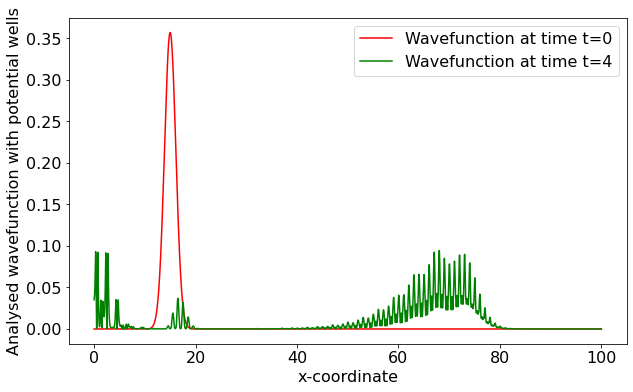

In [75]:
# The wavefunction is plotted with the potential wells this time
def task4():
    
    dx = 1/32
    N = int(L/dx)
    arr = np.linspace(0,L,N)
    # Initialise the wavefunction
    psi_x, wavefunc = wavefunction_zero(v)
    # Get the eigenvectors and eigenvalues of hamiltonian H
    """H = hamiltonian_V(dx)
    evals, evecs = eigsh(H, 550, which = "SM")"""
    main, off = hamiltonian_VPot(dx)
    evals, evecs = eigh_tridiagonal(main, off, select = 'i', select_range = (0,300))

    # Update the wavefunction position and the corresponding pdf
    a = evecs.T.dot(psi_x)
    # plot the first smallest values, exercise done as sanity check
    """for i in np.abs(evals).argsort()[:4]:
        plt.plot(arr, evecs[:,i])
    plt.show()"""
    # Spectral method is used again
    u = np.zeros(N, dtype = np.complex128) 

    for i in range (evals.size):
        u += a[i] * np.exp(evals[i] * tmax * (-1j)) * evecs[:,i]

    plt.plot(arr, wavefunc, color = 'r', label = "Wavefunction at time t=0")
    plt.plot(arr, u * np.conjugate(u), color = 'g', label = "Wavefunction at time t=4")
    plt.legend()
    plt.xlabel("x-coordinate")
    plt.ylabel("Analysed wavefunction with potential wells")
    plt.show()
    
task4()

# Task 5 (15p)

Calculate the probability $P_{1/2}$ of the particle moving through the point x=L/2 by integrating the probability current 

$
\large
\begin{align}
j = (\psi^*  \frac{\partial \psi}{\partial x} -
\psi \frac{\partial \psi^*}{\partial x})(x=L/2)
\end{align}
$

over time, for t=0...4. The probability can deviate from the true value by no more than $\pm$0.01 (hint: the correct value is between 0.5 and 1).

In the cell below, calculate the probability and print your answer.

In [78]:
# This cell deals with the probability current
dx = 1/32
N = int(L/dx)
main, off = hamiltonian_VPot(dx)
evals, evecs = eigh_tridiagonal(main, off, select = 'i', select_range = (0,1000))

def find_probability(u, a=evals, b=evecs):

    dx = 1/32
    N = int(L/dx)
    dt = dx
    t = 0
    prob = []
    time = []
    
    psi_x, wavefunc = wavefunction_zero(u)
    a = evecs.T.dot(psi_x)

    while(t < tmax):
        u0 = 0
        u0_dx = 0
        t += dt
        # Calculate the wavefunction at the middle after a given time t
        for i in range (evals.size):
            u0 += a[i] * np.exp(evals[i] * t * (-1j)) * evecs[int(N/2) - 1,i]
            u0_dx += a[i] * np.exp(evals[i] * t * (-1j)) * evecs[int(N/2),i]
        
        # The variables below stand for the formula for probability current
        d_u0 = (u0_dx - u0) / dx
        u0_conj = np.conjugate(u0)
        u0_dx_conj = np.conjugate(u0_dx)
        d_u0_conj = (u0_dx_conj - u0_conj) / dx
        prob.append(abs((u0_conj * d_u0 - u0 * d_u0_conj) * (-1j)))
        time.append(t)
        
    s = scipy.integrate.simps(prob, time) 
    return s

print("Probability of the particle being detected at x=L/2 is: " + str(find_probability(v)) )

Probability of the particle being detected at x=L/2 is: 0.8009307631913735


# Task 6 (15p)

Plot the probability $P_{1/2}$ as a function of particle energy E=0...100, for at least 100 equally-spaced values from this range. All $P_{1/2}$ values should be within $\pm$0.01 of the true values. Use the formula 

$
\large
\begin{align}
E = \frac{1}{4} v^2
\end{align}
$

to convert between energy and velocity (valid for Eqs. (1,2)).

Bonus question: can you explain why the plot looks like this?

Plot the probability in the cell below.

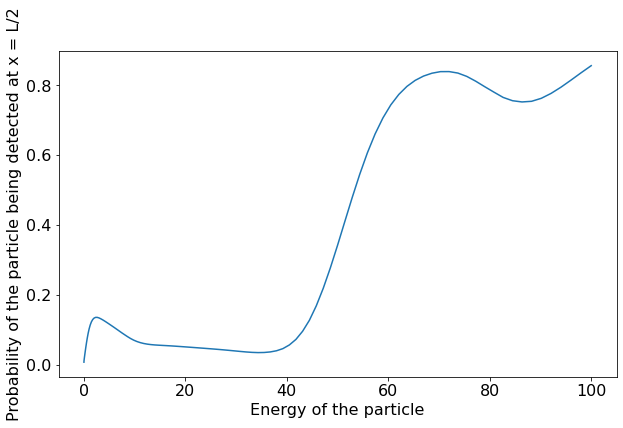

In [79]:
# Probability plotted as function of the energy 
def prob_speed():
    
    vel = np.linspace(0,20,100)
    prob = np.zeros(100)
    for i in range(len(vel)):
        prob[i] = find_probability(vel[i])
        vel[i] = 0.25 * vel[i]**2
    plt.plot(vel, prob)
    plt.xlabel("Energy of the particle")
    plt.ylabel("Probability of the particle being detected at x = L/2")
    plt.show()

prob_speed()

# Task 7 (10p)

Assume again the initial condition of equation (2) with v=16, and consider a disordered potential in which

V=70 for |x-i| < b$_i$ where i=0,1,...,100,

and b$_i$ is a random variable uniformly distributed on [0.125, 0.375].

Find the probability $P_{1/2}$ by averaging over 100 realizations of the random potential (must be accurate to $\pm$0.02). Plot the histogram of $P_{1/2}$. Comment on the value of $P_{1/2}$ compared with task 5.

In [80]:
# This is function for potential wells, a more generalized one
dx = 1/32
N = int(L/dx)
arr = np.linspace(0,L,N)

def H_V(p):

    main_diag = (2/(dx**2)) * np.ones(N)
    off_diag = (-1/(dx**2)) * np.ones(N-1)
    main_diag[0] = main_diag[1]/2
    main_diag[N-1] = main_diag[1]/2
    for i in range(N):
        if( (i*dx - int(i*dx) < p) or (i*dx - int(i*dx) > (1-p)) ):
            main_diag[i] += 70
    return main_diag, off_diag

In [81]:
# For each random generated b_i value, I calculated the overall probability of the particle passing through x = L/2
# I took all the probabilities and divided them by 100 - I calculated the mean probability

s = 0
for i in range(100):
    
    potV = np.random.uniform(0.125, 0.375)
    main, off = H_V(potV)
    evals, evecs = eigh_tridiagonal(main, off, select = 'i', select_range = (0,500))
    
    s += find_probability(v, evals, evecs)

s = s/100
print(s)

0.839927429035335
